# COMP0123 Complex Networks and Webs Coursework 1

Importing libraries

In [244]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Task 0 - Preparation of Network Data

In [312]:
n_count = 2068
e_count = 5163

### Creating our Author Network

- Among the millions of authors, firstly you extract all authors whose research interests are related to 'social network', including those with interests in 'Social network', 'social networks', 'human social network' etc.

In [294]:
# Creating our graph
G = nx.Graph()

In [295]:
# Retrieving indices of all author's who have an interest in 'social networks'
author_indices = []
interest = "social network"

with open("data/AMiner-Author.txt", 'r', encoding='utf-8') as f:
    current_author_index = None
    for line in f:
        line = line.strip()

        if line.startswith("#index"):
            current_author_index = line.split(' ')[1]
        
        if line.startswith("#t"):
            interests = line[2:]
            # Check if any variant of the interest is in the author's interests.
            if interest in interests.lower():
                author_indices.append(current_author_index)

In [296]:
# Adding all author indices to the graph
G.add_nodes_from(author_indices)
G.number_of_nodes()

9219

- Secondly, you extract all links (co-authorships) among the above authors. You should discard any authors with degree 0 (that have no link with any of the other authors) and any repeated links, so that you create a simple graph.

In [297]:
# Adding in edges
edges = []
author_indices = set(author_indices)

with open("data/AMiner-Coauthor.txt", 'r') as f:
    for line in f:
        author1, author2, _ = line.split()
        author1 = author1[1:]
        
        if (author1 in author_indices) and (author2 in author_indices):
            edges.append([author1, author2])
        

In [298]:
G.add_edges_from(edges)
G.number_of_edges()

12129

In [299]:
# Removing nodes with degree 0
F = nx.Graph()
fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > 0, G.edges())
F.add_edges_from(fedges)

- Thirdly, you extract the giant component in the above simple graph. For your information, the giant component should contain 2,068 unique nodes and 5,163 unique links. Note that link a-b is same as link b-a, which is a single unique link, not two links.

In [350]:
# Achieving giant component
author_network = F.subgraph(max(nx.connected_components(F), key=len))

In [301]:
# Achieving desired number of nodes
author_network.number_of_nodes()

2068

In [302]:
# Achieving desired number of edges
author_network.number_of_edges()

5163

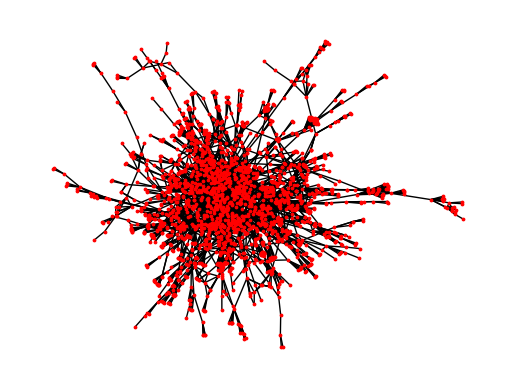

In [303]:
# Plotting Author Network
subax1 = plt.subplot()
options = {
    'node_color': 'red',
    'node_size': 3,
    'width': 1,
}
nx.draw(author_network, **options)

### Generating Random Network

We'll follow along with the Erdos-Renyi (ER) model: $G(N,M)$ Model

In [313]:
ER = nx.gnm_random_graph(n_count, e_count, seed= 42)

### Generating BA Network

$ E = m(N - N_{initial}) + E_{initial} $

$ 5163 = m(2068 - N_{initial}) + E_{initial} $


In [314]:
m = 3
n_initial = 520
e_initial = 519

In [315]:
# Creating our initial random graph
initial = nx.gnm_random_graph(n_initial, e_initial, seed= 42)
BA = nx.barabasi_albert_graph(n_count, m, initial_graph= initial, seed= 42)

## Task 1

- Calculate the average node degree and the maximum node degree of the 3 networks

$ \bar{k} \equiv \frac{1}{N} \sum^{N}_{i = 1} k_i = \frac{2E}{N}$

In [316]:
round(2 * e_count / n_count, 2)

4.99

In [317]:
"Author Network Max Degree: " + str(max(dict(author_network.degree()).values()))

'Author Network Max Degree: 51'

In [318]:
"Random Graph Max Degree: " + str(max(dict(ER.degree()).values()))

'Random Graph Max Degree: 13'

In [319]:
"BA Graph Max Degree: " + str(max(dict(BA.degree()).values()))

'BA Graph Max Degree: 48'

- Plot their degree distribution $P(k)$ on linear-linear scale and log-log scale,
respectively

$ P(k) = \frac{N_k}{N}$

In [320]:
def plot_degree_distribution(G, graph_name):    
    N_k = nx.degree_histogram(G)
    pk = [i/n_count for i in N_k]
    k = list(range(0,len(N_k)))
    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.title("Linear-Linear Scale (" + graph_name + ")")
    plt.xlabel("k")
    plt.ylabel("P(k)")
    plt.scatter(k, pk)

    plt.subplot(122)
    plt.title("Log-Log Scale (" + graph_name + ")")
    plt.xlabel("k")
    plt.ylabel("P(k)")
    plt.loglog(k, pk, 'o')

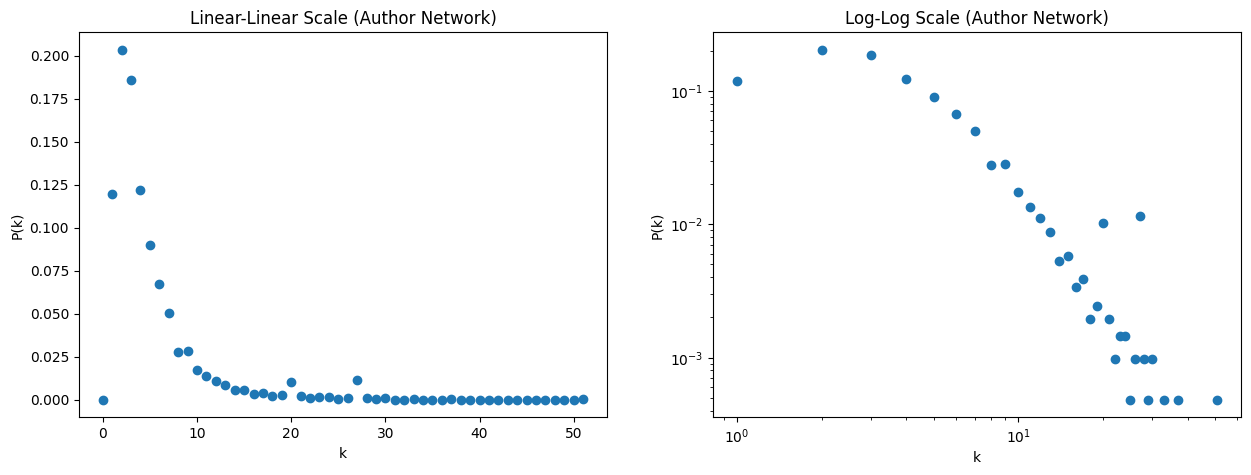

In [321]:
plot_degree_distribution(author_network, 'Author Network')

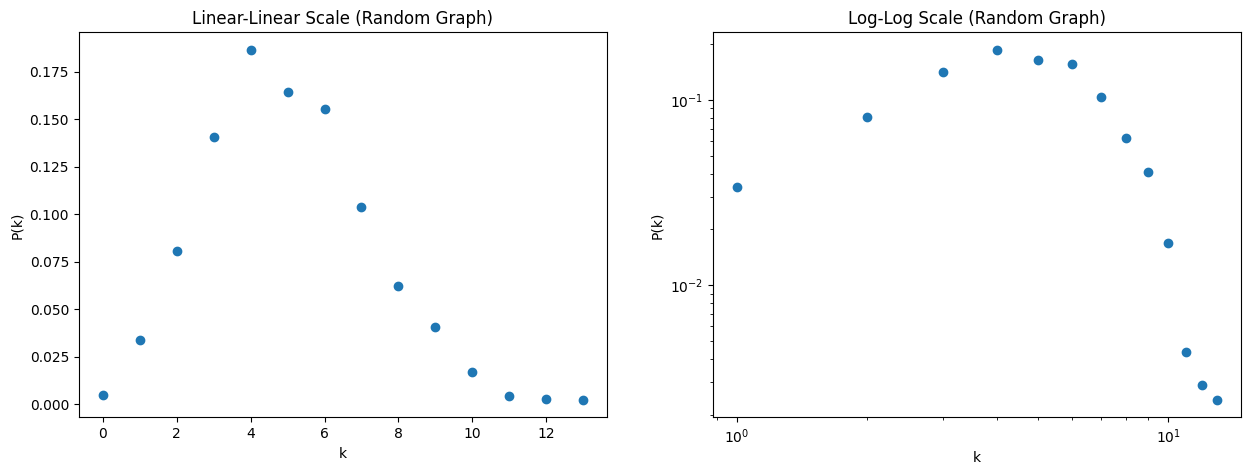

In [322]:
plot_degree_distribution(ER, "Random Graph")

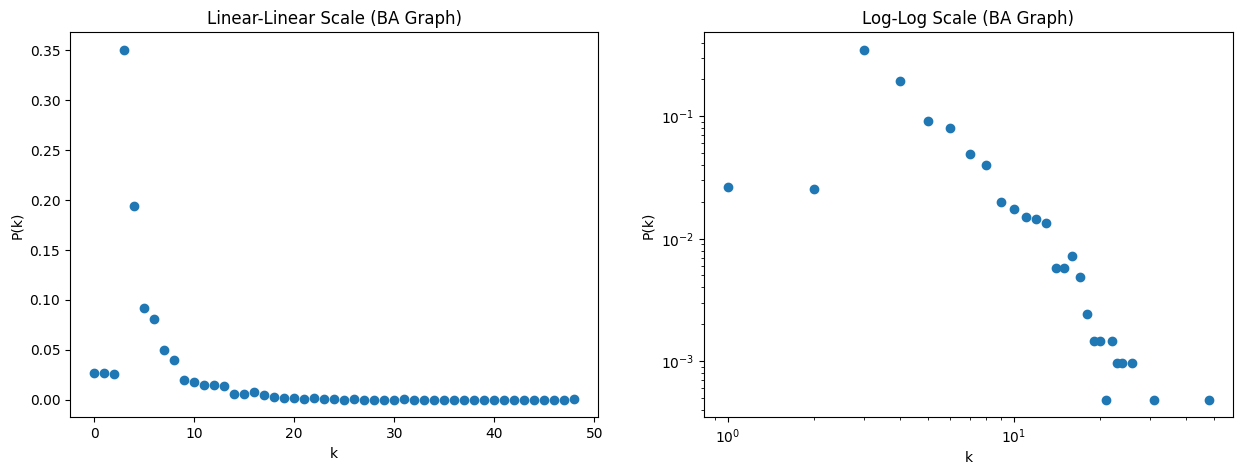

In [323]:
plot_degree_distribution(BA, "BA Graph")

- Estimate the power-law exponent of the degree distribution P(k) of the author
network only.
  -  You can fit a curve by using the function polyfit from the numpy library.
  -  Ideally, you can do the fitting on CCDF (the complementary cumulative
distribution function) on log-log scale.

In [324]:
def compute_power_law_exponent(G):
    hist = np.array(nx.degree_histogram(G))
    degrees = np.arange(len(hist))

    # Remove zeros from the histogram to avoid issues with log transformation
    non_zero = hist > 0
    degrees = degrees[non_zero]
    hist = hist[non_zero]

    # Fit a line to the log-transformed data
    coefficients = np.polyfit(np.log(degrees[degrees > 0]), np.log(hist[degrees > 0]), 1)
    return -round(coefficients[0], 2)

print(f"Estimated power-law exponent (alpha): {compute_power_law_exponent(author_network)}")

Estimated power-law exponent (alpha): 2.01


## Task 2

- Calculate and plot the nearest neighbour’s average degree $knn$ as a function of
node degree $k$, on log-log scale.

In [325]:
def plot_knn(G, graph_name):
    knn = nx.average_degree_connectivity(G)

    k = list(knn.keys())
    plt.figure(figsize=(20,5))

    plt.subplot(121)
    plt.title("Log-Log knn(k) Graph (" + graph_name + ")")
    plt.xlabel("k")
    plt.ylabel("P(k)")
    plt.loglog(k, list(knn.values()), 'o')

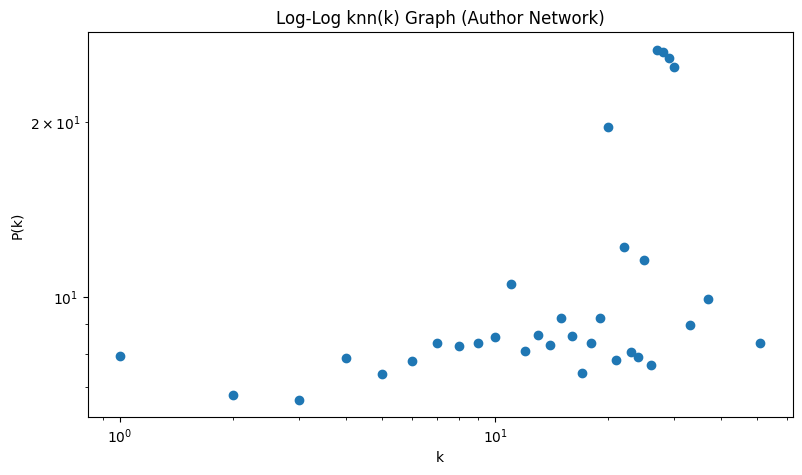

In [326]:
plot_knn(author_network, "Author Network")

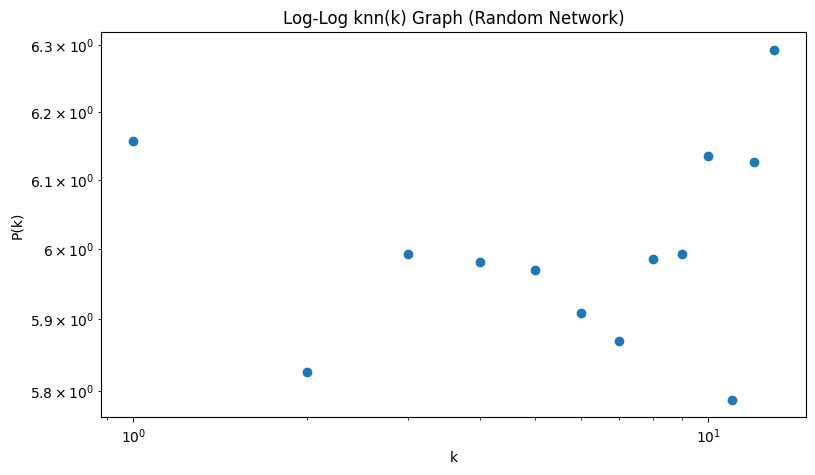

In [327]:
plot_knn(ER, "Random Network")

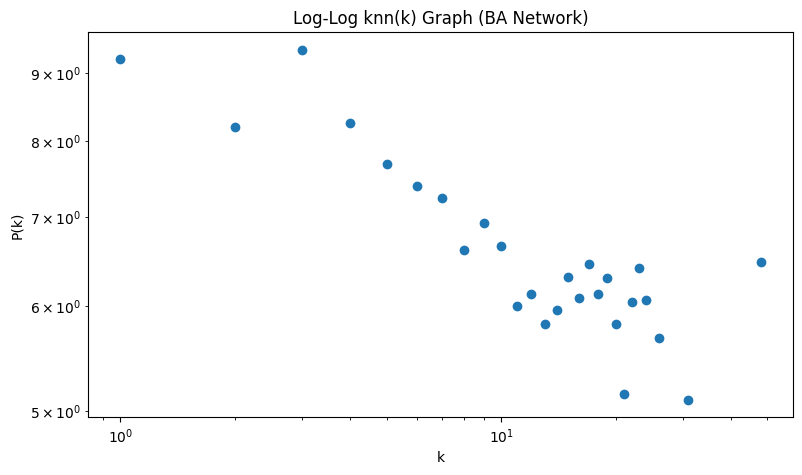

In [328]:
plot_knn(BA, "BA Network")

- Calculate the assortative coefficient of the networks

In [329]:
print(f"Author Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(author_network), 2))

Author Network Associative Coefficient:  0.47


In [330]:
print(f"Random Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(ER), 2))

Random Network Associative Coefficient:  0.01


In [331]:
print(f"BA Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(BA), 2))

BA Network Associative Coefficient:  -0.16


## Task 3

- Calculate the diameter and the average shortest path length of the network.

In [335]:
print("Diameter: " + str(nx.diameter(author_network)))

Diameter:19


In [337]:
print("Average Shortest Path Length: " + str(round(nx.average_shortest_path_length(author_network), 2)))

Average Shortest Path Length: 7.3


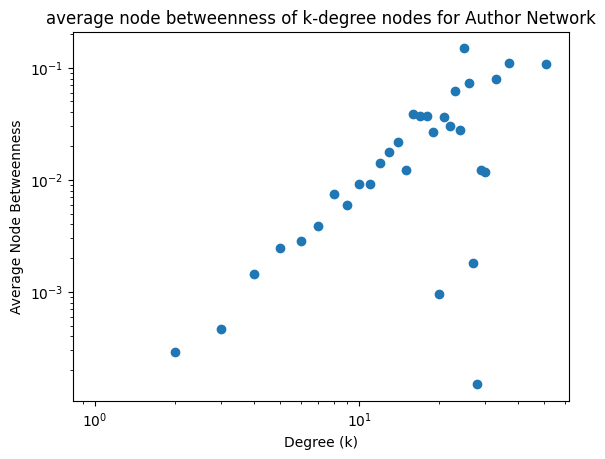

In [341]:
def average_betweenness_per_degree(G):
    """
    Compute the average normalized betweenness centrality of nodes for each degree k in a NetworkX graph G.

    Args:
    - G (nx.Graph): Input graph.

    Returns:
    - dict: A dictionary mapping each degree k to its average normalized betweenness centrality.
    """
    # Calculate normalized betweenness centrality for all nodes
    betweenness = nx.betweenness_centrality(G, normalized=True)

    # Create a dictionary to hold sum of betweenness centrality and count for each degree k
    degree_dict = {}
    for node, k in G.degree():
        if k not in degree_dict:
            degree_dict[k] = {'sum': 0, 'count': 0}
        degree_dict[k]['sum'] += betweenness[node]
        degree_dict[k]['count'] += 1

    # Calculate average betweenness centrality for each degree k
    avg_betweenness = {k: v['sum'] / v['count'] for k, v in degree_dict.items()}

    return avg_betweenness

# Calculate average betweenness per degree
avg_betweenness = average_betweenness_per_degree(author_network)

# Plotting on log-log scale
degrees = list(avg_betweenness.keys())
betweenness_values = list(avg_betweenness.values())

plt.loglog(degrees, betweenness_values, 'o')
plt.title('average node betweenness of k-degree nodes for Author Network')
plt.xlabel('Degree (k)')
plt.ylabel('Average Node Betweenness')
plt.show()

## Task 4

- Calculate and plot the rich-club coefficient as a function of node rank on log-log
scale.

- Calculate and plot the rich-club coefficient as a function of node degree on log-log scale

In [395]:
def plot_rich_club(G):

    # Calculate the rich-club coefficient
    rich_club = nx.rich_club_coefficient(G, normalized=False)

    sorted_degrees = sorted(rich_club.keys(), reverse=True)
    ranked_degrees = {k: i for i, k in enumerate(sorted_degrees, 1)}
    rich_club_ranks = {ranked_degrees[k]: rich_club[k] for k in sorted_degrees if rich_club[k] != 0}

    plt.figure(figsize=(15,5))

    # By Node Rank
    plt.subplot(121)
    plt.loglog(list(rich_club_ranks.keys()), list(rich_club_ranks.values()), 'o')
    plt.title('Rich-Club Coefficient vs. Node Rank')
    plt.xlabel('Node Rank')
    plt.ylabel('Rich-Club Coefficient')

    # Sort by degree for plotting
    degrees = sorted(rich_club.keys())
    coefficients = [rich_club[degree] for degree in degrees]
    # By Node Degree
    plt.subplot(122)
    plt.loglog(degrees, coefficients, 'o')
    plt.title('Rich-Club Coefficient vs. Node Degree')
    plt.xlabel('Node Degree (r)')
    plt.ylabel('Rich-Club Coefficient')
    plt.show()


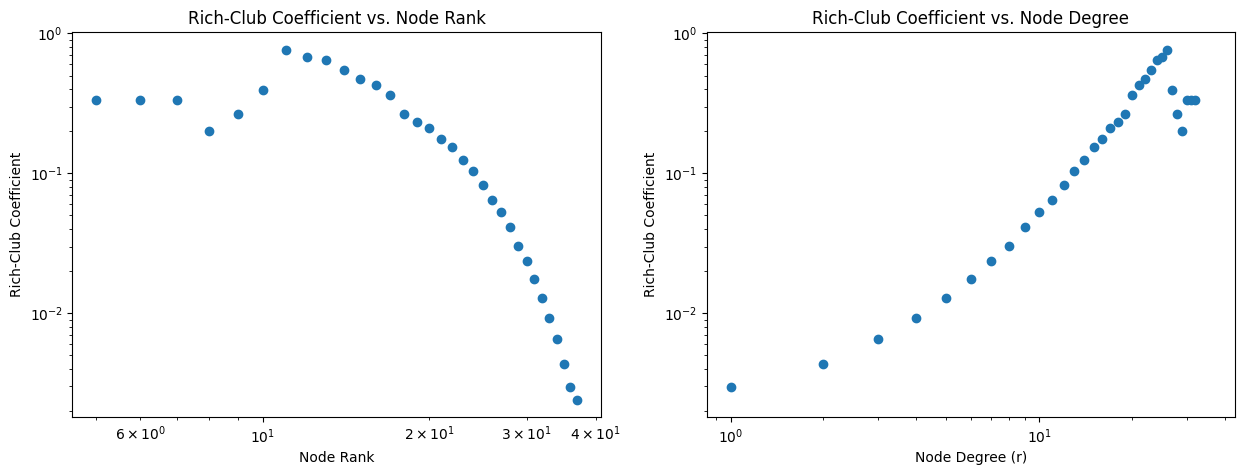

In [396]:
plot_rich_club(author_network)

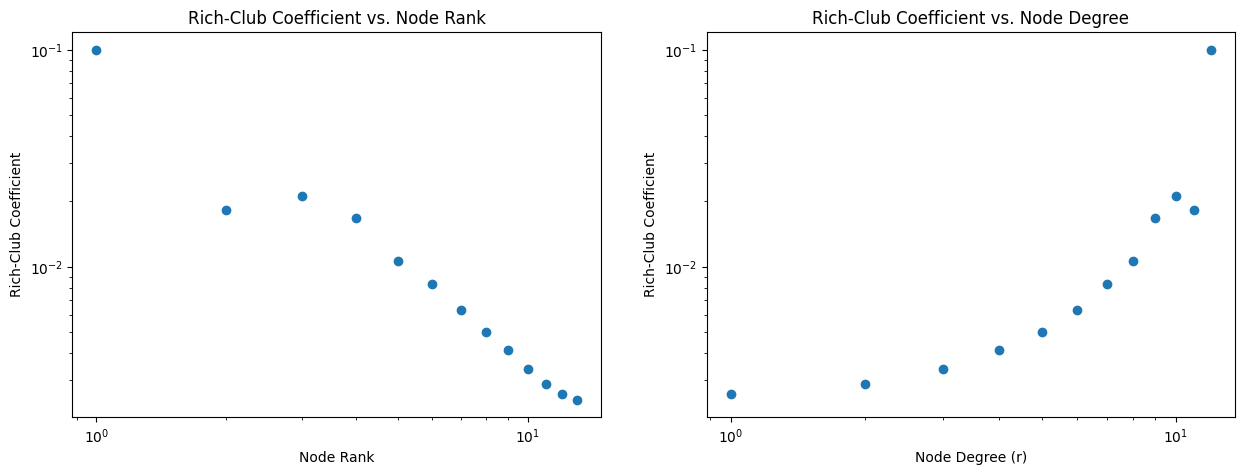

In [397]:
plot_rich_club(ER)

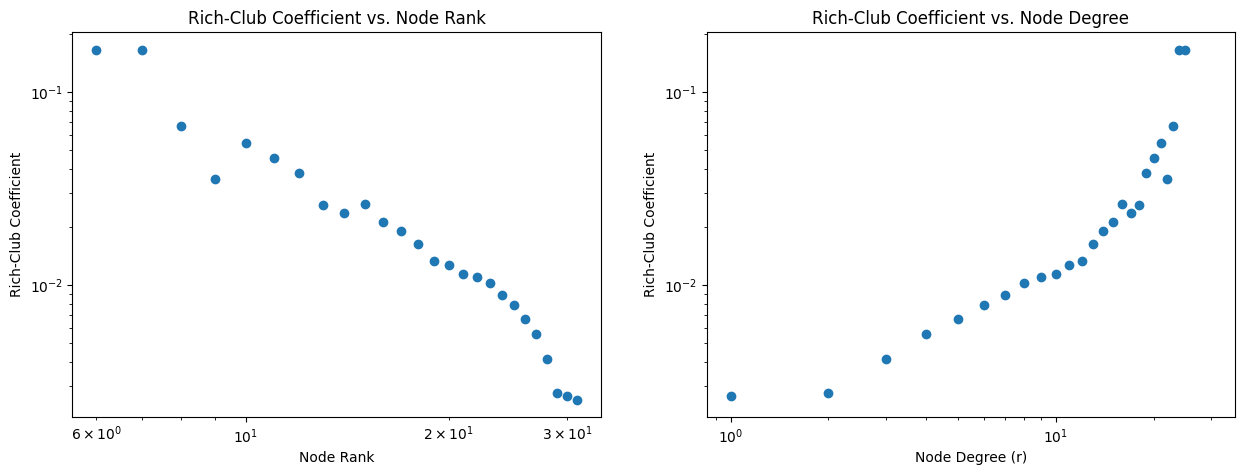

In [398]:
plot_rich_club(BA)

## Task 5

- Obtain the community structure (with the largest modularity value) of the 3
networks.

- Give the number of communities and the size (i.e. number of nodes) of the top 3
largest communities in each network

- Visualise the network and show each community with a different colour.

Author Network
Modularity Value: 0.88
Number of Communites: 56
Largest Community Size: 264
2nd Largest Community Size: 218
3rd Largest Community Size: 167


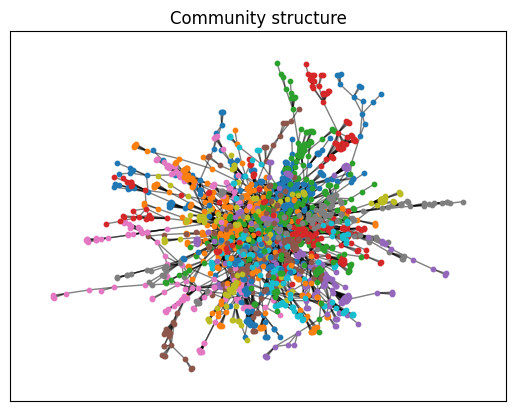

In [431]:
# Detect communities using the greedy modularity maximization
communities = list(nx.algorithms.community.greedy_modularity_communities(author_network))

# Calculate modularity
modularity_value = nx.community.modularity(author_network, communities)

# Community Information
print("Author Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(author_network, seed= 42)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(author_network, pos, community, node_size=10, node_color=f"C{i}")
nx.draw_networkx_edges(author_network, pos, alpha=0.5)
plt.title(f"Community structure")
plt.show()


Random Network
Modularity Value: 0.44
Number of Communites: 28
Largest Community Size: 221
2nd Largest Community Size: 221
3rd Largest Community Size: 189


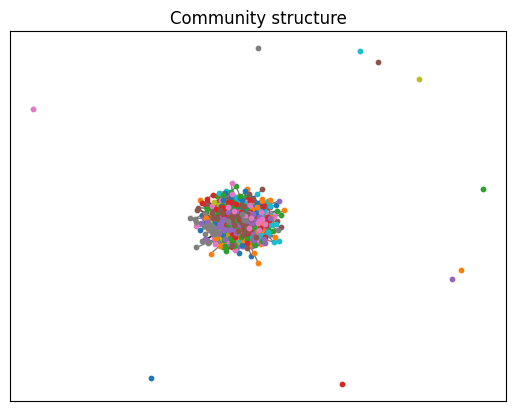

In [435]:
# Detect communities using the greedy modularity maximization
communities = list(nx.algorithms.community.greedy_modularity_communities(ER))

# Calculate modularity
modularity_value = nx.community.modularity(ER, communities)

# Community Information
print("Random Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(ER)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(ER, pos, community, node_size=10, node_color=f"C{i}")
nx.draw_networkx_edges(ER, pos, alpha=0.5)
plt.title(f"Community structure")
plt.show()

BA Network
Modularity Value: 0.43
Number of Communites: 75
Largest Community Size: 281
2nd Largest Community Size: 256
3rd Largest Community Size: 239


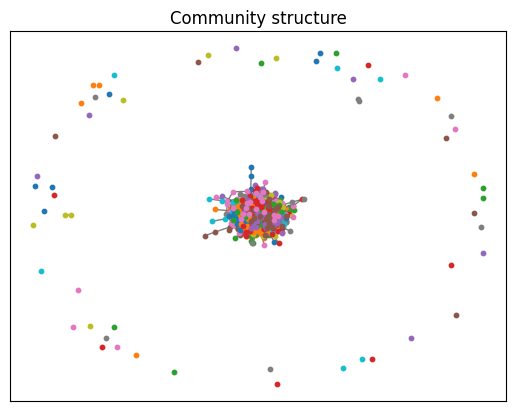

In [436]:
# Detect communities using the greedy modularity maximization
communities = list(nx.algorithms.community.greedy_modularity_communities(BA))

# Calculate modularity
modularity_value = nx.community.modularity(BA, communities)

# Community Information
print("BA Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(BA, seed= 42)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(BA, pos, community, node_size=10, node_color=f"C{i}")
nx.draw_networkx_edges(BA, pos, alpha=0.5)
plt.title(f"Community structure")
plt.show()

## Task 6